**Run cells in the numbered order. Sentiment analysis must be done before visualization generationt**



# 1) Setup Code For Sentiment Analyzer


##Package Installation and Imports

In [ ]:
!pip install essentia

In [ ]:
!pip install scikit-learn==1.3.1

In [ ]:
import essentia
import essentia.standard as es
import librosa
import json
import soundfile as sf
import datetime
import numpy as np
import pandas as pd
from google.colab import drive
import joblib
genNumber=1

## Feature Extraction

In [ ]:
def extractFeatures(audioPath):
  audioSignal, sr = librosa.load(audioPath)
  #12x3=36
  chroma=librosa.feature.chroma_stft(y=audioSignal, sr=sr)
  chromafeat = np.concatenate((np.mean(chroma, axis=1), np.std(chroma, axis=1), np.var(chroma, axis=1)))

  #13x3=39
  mfcc = librosa.feature.mfcc(sr=sr, y=audioSignal, n_mfcc=13)
  mfccfeat = np.concatenate((np.mean(mfcc, axis=1), np.std(mfcc, axis=1), np.var(mfcc, axis=1)))

  #3
  rms=librosa.feature.rms(y=audioSignal)
  rmsfeat = np.concatenate((np.mean(rms, axis=1), np.std(rms, axis=1), np.var(rms, axis=1)))

  #3
  zcr=librosa.feature.zero_crossing_rate(audioSignal)
  zcrfeat = np.concatenate((np.mean(zcr, axis=1), np.std(zcr, axis=1), np.var(zcr, axis=1)))

  #1
  onsetEnv = librosa.onset.onset_strength(y=audioSignal, sr=sr)
  tempo = librosa.feature.tempo(onset_envelope=onsetEnv, sr=sr)

  #3
  centroid = librosa.feature.spectral_centroid(y=audioSignal, sr=sr)
  centroidfeat = np.concatenate((np.mean(centroid, axis=1), np.std(centroid, axis=1), np.var(centroid, axis=1)))

  #3
  bandwidth = librosa.feature.spectral_bandwidth(y=audioSignal, sr=sr)
  bandwidthfeat = np.concatenate((np.mean(bandwidth, axis=1), np.std(bandwidth, axis=1), np.var(bandwidth, axis=1)))

  #3
  flatness = librosa.feature.spectral_flatness(y=audioSignal)
  flatnessfeat = np.concatenate((np.mean(flatness, axis=1), np.std(flatness, axis=1), np.var(flatness, axis=1)))

  #3
  rolloff = librosa.feature.spectral_rolloff(y=audioSignal,sr=sr)
  rollofffeat = np.concatenate((np.mean(rolloff, axis=1), np.std(rolloff, axis=1), np.var(rolloff, axis=1)))

  #6x3=18
  tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audioSignal), sr=sr)
  tonnetzfeat = np.concatenate((np.mean(tonnetz, axis=1), np.std(tonnetz, axis=1), np.var(tonnetz, axis=1)))

  #13x3=39
  tempogram = librosa.feature.tempogram(y=audioSignal, sr=sr)
  tgr = librosa.feature.tempogram_ratio(tg=tempogram, sr=sr)
  tgrfeat = np.concatenate((np.mean(tgr, axis=1), np.std(tgr, axis=1), np.var(tgr, axis=1)))


  audioeq = es.EqloudLoader(filename=audioPath, sampleRate=44100)()

  #predominant melody
  pitchextractor = es.PredominantPitchMelodia(frameSize=2048, hopSize=128)
  pitchvalues, pitchconfidence = pitchextractor(audioeq)
  #3
  pitchfeat = np.concatenate((np.mean(np.asarray([pitchvalues]), axis=1), np.std(np.asarray([pitchvalues]), axis=1), np.var(np.asarray([pitchvalues]), axis=1)))

  #AfterMaxToBeforeMaxEnergyRatio
  #1
  AMBMEnergyratio=es.AfterMaxToBeforeMaxEnergyRatio()(pitchvalues)

  audio= es.MonoLoader(filename=audioPath,sampleRate=22050)()

  #3 each except inharmonicity which is #3x3=9
  spectralfeatures = es.LowLevelSpectralExtractor(frameSize=2048, hopSize=512, sampleRate=22050)(audio)
  #pitch_salience
  pitchsaliencefeat = np.concatenate((np.mean(np.asarray([spectralfeatures[8]]), axis=1), np.std(np.asarray([spectralfeatures[8]]), axis=1), np.var(np.asarray([spectralfeatures[8]]), axis=1)))
  #spectral_complexity
  speccomplexfeat = np.concatenate((np.mean(np.asarray([spectralfeatures[12]]), axis=1), np.std(np.asarray([spectralfeatures[12]]), axis=1), np.var(np.asarray([spectralfeatures[12]]), axis=1)))
  #spectral_flux
  specfluxfeat = np.concatenate((np.mean(np.asarray([spectralfeatures[21]]), axis=1), np.std(np.asarray([spectralfeatures[21]]), axis=1), np.var(np.asarray([spectralfeatures[21]]), axis=1)))
  #inharmonicity
  inharmonicityfeat = np.concatenate((np.mean(np.asarray([spectralfeatures[26]]), axis=1), np.std(np.asarray([spectralfeatures[26]]), axis=1), np.var(np.asarray([spectralfeatures[26]]), axis=1)))
  #tristimulus
  tristimulusfeat = np.concatenate((np.mean(spectralfeatures[27], axis=0), np.std(spectralfeatures[27], axis=0), np.var(spectralfeatures[27], axis=0)))
  #Odd-to-Even Harmonic Energy Ratio
  O2Eharmonicfeat = np.concatenate((np.mean(np.asarray([spectralfeatures[28]]), axis=1), np.std(np.asarray([spectralfeatures[28]]), axis=1), np.var(np.asarray([spectralfeatures[28]]), axis=1)))

  key,scale,strength = es.KeyExtractor(frameSize=2048,hopSize=512,sampleRate=22050)(audio)
  key=['Ab','A','Bb','B','C','C#','D','Eb','E','F','F#','G'].index(key)

  if scale=="major":
    scale=1
  else:
    scale =-1

  #1
  tuningfreq = float(np.mean(es.TuningFrequencyExtractor(frameSize=2048,hopSize=512)(audio)))

  #1
  loudness=es.Loudness()(audio)
  #1
  danceability=es.Danceability()(audio)[0]
  #3
  logAttackT=list(es.LogAttackTime(sampleRate=22050)(audio))

  #188 total features
  features = np.concatenate((chromafeat, mfccfeat, rmsfeat, zcrfeat, tempo, \
                              centroidfeat, bandwidthfeat, flatnessfeat, rollofffeat,\
                              tonnetzfeat, tgrfeat,  np.array(logAttackT + [loudness,danceability]),\
                              pitchfeat, pitchsaliencefeat, speccomplexfeat, specfluxfeat, \
                              inharmonicityfeat, tristimulusfeat, O2Eharmonicfeat, np.asarray([AMBMEnergyratio, key, scale, strength, tuningfreq]) ))

  return features


## Get SVM Models

In [ ]:
!rm -rf Music-Sentiment-Analyzer-Models
!git clone https://github.com/mynameamen/Music-Sentiment-Analyzer-Models.git

Cloning into 'Music-Sentiment-Analyzer-Models'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 2), reused 7 (delta 1), pack-reused 0
Receiving objects: 100% (8/8), 201.14 KiB | 2.72 MiB/s, done.
Resolving deltas: 100% (2/2), done.


## SVM Model Setup

In [ ]:
def SVM1(selfeaturedata):
  SVM1 = joblib.load("Music-Sentiment-Analyzer-Models/Half_Classifier_Model.pkl")
  prediction=SVM1.predict(np.asarray(selfeaturedata))
  return prediction[0]

In [ ]:
def SVM2(selfeaturedata):
  SVM2 = joblib.load("Music-Sentiment-Analyzer-Models/TopHalf_Classifier_Model.pkl")
  prediction=SVM2.predict(np.asarray(selfeaturedata))
  return prediction[0]

In [ ]:
def SVM3(selfeaturedata):
  SVM3 = joblib.load("Music-Sentiment-Analyzer-Models/BottomHalf_Classifier_Model.pkl")
  prediction=SVM3.predict(np.asarray(selfeaturedata))
  return prediction[0]

## Sentiment Classification

In [ ]:
def getSentiment(filename):
  audio_file = filename
  y, sr = librosa.load(audio_file,mono=True)
  duration = librosa.get_duration(y=y, sr=sr)
  if sr != 22050:
    y=librosa.resample(y, orig_sr=sr, target_sr=22050)
    sr=22050
  time=30
  start=0
  stop=sr*time
  chunks=[]
  removed=0
  while stop < len(y)-1:
    chunks.append(y[start:stop])
    start=stop
    stop+=(sr*time)
  chunks.append(y[start:])
  if (len(chunks[-1])/22050) < (15):
    removed = len(chunks[-1])/22050
    chunks = chunks[:-1]


  headers=["chromaC_mean", "chromaC#_mean", "chromaD_mean", "chromaD#_mean", "chromaE_mean", "chromaF_mean", "chromaF#_mean", "chromaG_mean", \
         "chromaG#_mean", "chromaA_mean", "chromaA#_mean", "chromaB_mean", "chromaC_std", "chromaC#_std", "chromaD_std", "chromaD#_std", "chromaE_std", \
         "chromaF_std", "chromaF#_std", "chromaG_std", "chromaG#_std", "chromaA_std", "chromaA#_std", "chromaB_std", "chromaC_var", "chromaC#_var", "chromaD_var", \
         "chromaD#_var", "chromaE_var", "chromaF_var", "chromaF#_var", "chromaG_var", "chromaG#_var", "chromaA_var", "chromaA#_var", "chromaB_var", "mfcc1_mean", \
         "mfcc2_mean", "mfcc3_mean", "mfcc4_mean", "mfcc5_mean", "mfcc6_mean", "mfcc7_mean", "mfcc8_mean", "mfcc9_mean", "mfcc10_mean", "mfcc11_mean", "mfcc12_mean", \
         "mfcc13_mean", "mfcc1_std", "mfcc2_std", "mfcc3_std", "mfcc4_std", "mfcc5_std", "mfcc6_std", "mfcc7_std", "mfcc8_std", "mfcc9_std", "mfcc10_std", "mfcc11_std", \
         "mfcc12_std", "mfcc13_std", "mfcc1_var", "mfcc2_var", "mfcc3_var", "mfcc4_var", "mfcc5_var", "mfcc6_var", "mfcc7_var", "mfcc8_var", "mfcc9_var", "mfcc10_var", "mfcc11_var", \
         "mfcc12_var", "mfcc13_var", "rms_mean", "rms_std", "rms_var", "zcr_mean", "zcr_std", "zcr_var", "tempo", "centroid_mean", "centroid_std", "centroid_var", "bandwidth_mean", \
         "bandwidth_std", "bandwidth_var", "flatness_mean", "flatness_std", "flatness_var", "rolloff_mean", "rolloff_std", "rolloff_var", "tonnetz0_mean", "tonnetz1_mean", \
         "tonnetz2_mean", "tonnetz3_mean", "tonnetz4_mean", "tonnetz5_mean", "tonnetz0_std", "tonnetz1_std", "tonnetz2_std", "tonnetz3_std", "tonnetz4_std", "tonnetz5_std", \
         "tonnetz0_var", "tonnetz1_var", "tonnetz2_var", "tonnetz3_var", "tonnetz4_var", "tonnetz5_var", "tgr0_mean", "tgr1_mean", "tgr2_mean", "tgr3_mean", "tgr4_mean", "tgr5_mean",\
         "tgr6_mean", "tgr7_mean", "tgr8_mean", "tgr9_mean", "tgr10_mean", "tgr11_mean", "tgr12_mean", "tgr0_std", "tgr1_std", "tgr2_std", "tgr3_std", "tgr4_std", "tgr5_std", "tgr6_std",\
         "tgr7_std", "tgr8_std", "tgr9_std", "tgr10_std", "tgr11_std", "tgr12_std", "tgr0_var", "tgr1_var", "tgr2_var", "tgr3_var", "tgr4_var", "tgr5_var", "tgr6_var", "tgr7_var", "tgr8_var", \
         "tgr9_var", "tgr10_var", "tgr11_var", "tgr12_var", "logattacktime", "attackstart", "attackstop", "loudness", "danceability", "predominantpitch_mean", "predominantpitch_std",\
         "predominantpitch_var", "pitchsalience_mean", "pitchsalience_std", "pitchsalience_var", "complexity_mean", "complexity_std", "complexity_var", "flux_mean", "flux_std", "flux_var",\
         "inharmonicity_mean", "inharmonicity_std", "inharmonicity_var", "tristimulus1_mean", "tristimulus2_mean", "tristimulus3_mean", "tristimulus1_std","tristimulus2_std","tristimulus3_std",\
         "tristimulus1_var", "tristimulus2_var", "tristimulus3_var", "oddevenratio_mean", "oddevenratio_std", "oddevenratio_var", "AMBMenergyratio", "key", "scale", "strength", "tuningfrequency"]
  results=[]
  for chunk in chunks:
    output_file = f"temp.mp3"
    sf.write(output_file, chunk, sr)
    featuredata= np.asarray([list(extractFeatures("temp.mp3"))])
    featuredata= pd.DataFrame(featuredata, columns=headers)
    selectedheaders = json.load(open('Music-Sentiment-Analyzer-Models/SelectedHeaders.json'))
    SVM1predict=SVM1(featuredata[selectedheaders["SVM1"]])
    if SVM1predict == 0:
      SVM2predict=SVM2(featuredata[selectedheaders["SVM2"]])
      if SVM2predict == 0:
        results.append('Q1')
      elif SVM2predict == 1:
        results.append('Q2')
    elif SVM1predict == 1:
      SVM3predict=SVM3(featuredata[selectedheaders["SVM3"]])
      if SVM3predict == 0:
        results.append('Q3')
      elif SVM3predict == 1:
        results.append('Q4')
  results.append(duration)
  results.append(removed)
  return results



In [ ]:
quadrants={"Q1":["Exuberance", "Excited", "Aroused", "Astonished", "Delighted", "Glad", "Happy", "Pleased"], \
           "Q2":["Anxiety", "Alarmed", "Afraid", "Angry", "Tense", "Distressed", "Frustrated", "Annoyed"], \
           "Q3":["Depression", "Miserable", "Depressed", "Sad", "Gloomy", "Bored", "Droopy", "Tired", "Sleepy"], \
           "Q4":["Contentment", "Satisfied", "Content", "Calm", "Serene", "Ease", "Relaxed"]}

In [ ]:
def chunktime(h,end):
  if (h+1)*30<end:
    s= f"Chunk: {h+1} From " + str(datetime.timedelta(seconds=h*30))+" To "+str(datetime.timedelta(seconds=(h+1)*30))
  else:
    s= f"Chunk: {h+1} From " + str(datetime.timedelta(seconds=h*30))+" To "+str(datetime.timedelta(seconds=round(end)))
  return s

In [ ]:
def sentimentoutput(musicSentiment):
  h=0
  output = ''
  if musicSentiment[-1] != 0:
    output = output+ 'Song segment from '+ str(datetime.timedelta(seconds=round(musicSentiment[-2]-musicSentiment[-1])))+ ' to '+ str(datetime.timedelta(seconds=round(musicSentiment[-2]))) +' could not be analyzed due to lack of audio data\n'
  for chunkSentiment in musicSentiment[:-2]:
    output = output + '\n' +str(chunktime(h,musicSentiment[-2])) +'\n'
    sentimentList=quadrants[chunkSentiment]
    output = output + '\n' + f"Music Sentiment: {chunkSentiment}-{sentimentList[0]}\nEmotions in this quadrant: "
    output = output + ", ".join(sentimentList[1:]) + "\n"
    h+=1
  return output

#Sentiment Analyzer

In [ ]:
# @title ##2) Upload Music Audio

# @markdown ##Select audio file to analyze
from google.colab import files
uploaded = files.upload()
filename = next(iter(uploaded))

Saving 8.  Promenade IV.mp3 to 8.  Promenade IV.mp3


In [ ]:
# @title ##3) Get Music Sentiment

# @markdown ##Run to get Music sentiment. Sentiment analysis is only done in 30 second segments
musicSentiment=getSentiment(filename)
print(sentimentoutput(musicSentiment))


Chunk: 1 From 0:00:00 To 0:00:30

Music Sentiment: Q3-Depression
Emotions in this quadrant: Miserable, Depressed, Sad, Gloomy, Bored, Droopy, Tired, Sleepy

Chunk: 2 From 0:00:30 To 0:01:00

Music Sentiment: Q3-Depression
Emotions in this quadrant: Miserable, Depressed, Sad, Gloomy, Bored, Droopy, Tired, Sleepy

Chunk: 3 From 0:01:00 To 0:01:30

Music Sentiment: Q2-Anxiety
Emotions in this quadrant: Alarmed, Afraid, Angry, Tense, Distressed, Frustrated, Annoyed

Chunk: 4 From 0:01:30 To 0:01:54.965986

Music Sentiment: Q2-Anxiety
Emotions in this quadrant: Alarmed, Afraid, Angry, Tense, Distressed, Frustrated, Annoyed



## 4) Setup Code For Visualization Generation

In [4]:
!pip install openai
!pip install ipyplot
import ipyplot
from google.colab import userdata
from openai import OpenAI
from IPython.display import Image
from PIL import Image
import requests
import time

In [ ]:
visualsentiment=[]
for i in musicSentiment[:-2]:
  visualsentiment.append(", ".join(quadrants[i]))
Noimages = len(visualsentiment)

In [ ]:
def generatePrompt(subject, style, emotions, client):

  completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
      {"role": "system","content":"You're an emotion based prompt generator for a text to image model. You will be given a subject, style and emotions\
      by a user. You must develop a prompt that will be used to generate an image that has the given subject in the given style and conveys the given emotion. limit the direct use of\
      emotions given in the prompt use synonyms relevant to the subject and style.\
      You must:\
      -Generate only the prompt\
      -Write the prompt as firstly highlighting the subject and style followed by descriptive comma-separated phrases\
      -Limit directly using the words in the given emotions use synonyms relevent to the subject and style\
      For example:\
      Input: Subject: man on the moon\
      Style: minimalist, starry\
      Emotions: Contentment, Satisfied, Content, Calm, Serene, Ease, Relaxed\
      Output: A man on the moon in a minimalist style, vastness of space, a starry night sky, man with peaceful smile, serene atmosphere"},
      {"role": "user","content": f"Subject: {subject}\
      Style: {style}\
      Emotions: {emotions}"}],
    max_tokens=150,
    temperature=1.3,
  )

  return completion.choices[0].message.content


In [ ]:
def generateVisuallization(client,DALLEprompt, DALLE_Style):
  if DALLE_Style=='V' or DALLE_Style=='v': Style='vivid'
  if DALLE_Style=='N' or DALLE_Style=='n': Style='natural'
  response = client.images.generate(
    model="dall-e-3",
    prompt=DALLEprompt,
    size="1024x1024",
    quality="standard",
    n=1,
    style=Style
  )
  return response.data[0].url

In [ ]:
def saveImage(imageURL,imageName):
  with open(imageName +'.png', 'wb') as handle:
    response = requests.get(imageURL, stream=True)

    if not response.ok:
        print(response)

    for block in response.iter_content(1024):
        if not block:
            break

        handle.write(block)

# Visualization Generation


In [ ]:
# @title ##5) API Key Setup

# @markdown ##Store API key as a colab secret named 'OPENAIKEY'
client = OpenAI(api_key=userdata.get('OPENAIKEY'),)

In [ ]:
# @title ##6) Enter Visualization Input. Run after each change

# @markdown ##Enter details about subject (e.g. A man on the moon) For each 30 second segment of the song. Seperate subjects using semocolons (e.g. man;girl;family)
subject = 'earth;moon;stars;earth' # @param {type:"string"}
subjects = subject.split(';')
# @markdown ##Enter style descriptors (e.g. minimalist, watercolour etc.)  For each 30 second segment of the song. Seperate syles using semocolons
style = 'abstract;abstract;abstract;paint' # @param {type:"string"}
styles = style.split(';')
# @markdown ##Choose Generation Style for each visualization. For each 30 second segment put 'V' for Vivid and 'N' for Natural seperated by semicolons. (e.g. V;N;N;V)

# @markdown Vivid causes the model to lean towards generating hyper-real and dramatic images. Natural causes the model to produce more natural, less hyper-real looking images.
DALLE_Style = 'V;N;v;N' # @param {type:"string"}
DALLE_Styles = DALLE_Style.split(';')

if len(subjects) < Noimages: print('Not enough subject descriptions')
if len(subjects) > Noimages: print('Too many subject descriptions')

if len(styles) < Noimages: print('Not enough style descriptions')
if len(styles) > Noimages: print('Too many style descriptions')

if len(DALLE_Styles) < Noimages: print('Not enough generation styles descriptionsg')
if len(DALLE_Styles) > Noimages: print('Too many generation styles descriptionsg')



In [ ]:
# @title ##7) Get Visualization Prompt

# @markdown ##Prompts for each visualization will be generated and shown below
if (len(subjects) and len(styles) and len(DALLE_Styles)):
  DALLEprompt=[]
  for i in range(Noimages):
    DALLEprompt.append(generatePrompt(subjects[i], styles[i], visualsentiment[i], client))
    print("Image Prompt: ",DALLEprompt[i])
else:
  print('Check Visualization input')

Image Prompt:  Earth depicted in an abstract style, depressed color palette, desolate landscapes, gloomy atmosphere, tired planet, droopy shapes and forms
Image Prompt:  The moon in an abstract style, distorted shapes, dark hues, a sense of loneliness, somber atmosphere, melancholic aura
Image Prompt:  Stars depicted in an abstract style, chaotic constellation patterns, a sense of unease, swirling shapes and lines, an atmosphere of tension and restlessness, distorted and fragmented imagery, a feeling of disarray and disquiet
Image Prompt:  A galaxy in an abstract style, swirling and chaotic, colors blending in frenzy, vastness that overwhelms, a sense of unease and tension, a turbulent and turbulent atmosphere.


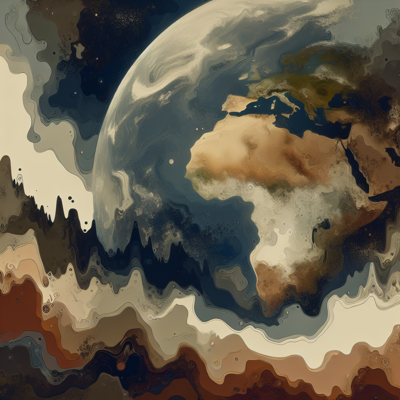

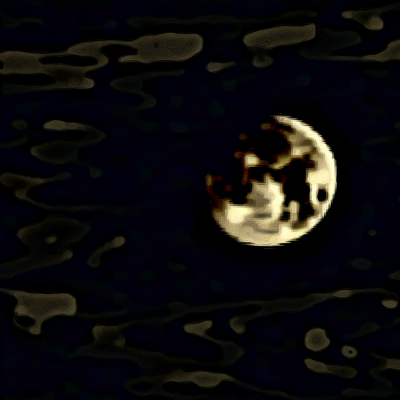

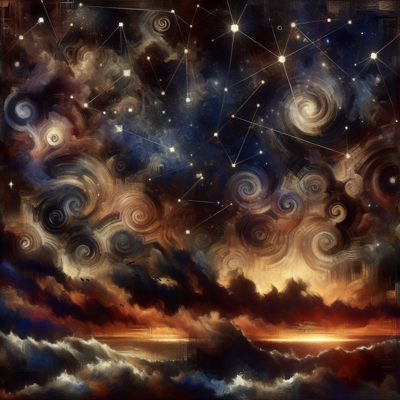

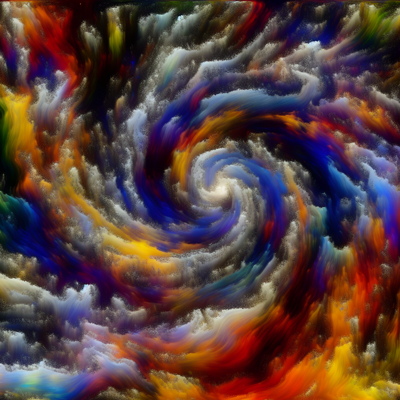

In [9]:
# @title ##8) Generate Visualization

# @markdown ##Images will be saved in files named 'image-#.png'.
imageData=[]
for i in range(Noimages):
  imageData.append(generateVisuallization(client, DALLEprompt[i], DALLE_Styles[i]))
  if i<(NoImages-1):
    time.sleep(63)
for i in range(Noimages):
  saveImage(imageData[i],'image-'+str(i))

for i in range(4):
    img = Image.open(f'image-{i}.png')
    img_resized = img.resize((400, 400))
    display(img_resized)